# Predicting Fatalities in Fatal Car Crashes from the US FARS database (2019)

In [38]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Introduction and Initial Statement


There were 33,244 fatal motor vehicle crashes in the United States in 2019 in which 36,096 deaths occurred. This resulted in 11.0 deaths per 100,000 people and 1.11 deaths per 100 million miles traveled. This project considers what features of the person / accident and vehicle contributed to these deaths. 

We have a data frame consisting of variables relating to fatal car crashes. This data frame was constructed by merging several auxiliary data frames from the FARS database (Fatality Analysis Report System), the construction of the data frame used within this notebook can be found within the folder named 'initial cleaning and augmentation'. 

The aim of this project is to identify which attributes of the person, accident or vehicle could lead to a correct prediction of death. The hope is that the data could then be used to identify those individuals at the highest risk of death, allowing resources from the emergency services etc. to be directed towards these cases, or for educational purposes to be used to inform drivers how to avoid fatal crashes.

Notes: 

1. As the data frame shows only those crashes were at least one fatality was recorded single vehicles with single persons (for example a motorcycle collision with a tree where the bike had no other passengers) have been excluded, as these are a certainty of death. 


2. Pedestrians have also been excluded below as a consequence of these instances have missing values for most of the features we are interested in (such as vehicle type, manner of collision). 

## Cleaning 

Notes:

1. Safety Measure: This column shows whether the person involved in the crash used a safety measure, for car passengers this represents whether the person wore a seatbelt (1 for yes and 0 for no), for motorcycle passengers this column indicates whether they wore a helmet (1 for yes and 0 for no)


2. Speeding, ejected and Rollover: Binary columns, 1 = Yes, 0 = No


3. Age is imputed as the median value for the lowest inferred age range taken from binary columns 

In [39]:
import numpy as np
import pandas as pd

In [40]:
df = pd.read_csv(
    '/Users/gemmaboyle/Desktop/GA-DSI/Capstone/Fatal Crashes/Initial cleaning and augmentation/fatal_crashes.csv')

In [41]:
df.head(2)

,Unnamed: 0,ST_CASE,blood_alcohol,ejected,fatality,person_type,vehicle_no,person_no,age,safety_measure,vehicles_in_crash,day_of_week,time_of_day,manner_of_collision,state,vehicle_type,impact_point,licence_status,speeding,rollover
0,0,10001,Not Tested,Not Ejected,0,Driver,1,1,32.0,1,2,Weekday,Daytime,Rear-End,Alabama,Passenger Car,Front,Invalid,1.0,0.0
1,1,10001,Not Tested,Not Ejected,1,Occupant,1,2,52.0,1,2,Weekday,Daytime,Rear-End,Alabama,Passenger Car,Front,Invalid,1.0,0.0


In [42]:
df = df.drop(columns='Unnamed: 0')

In [43]:
df.columns

Index(['ST_CASE', 'blood_alcohol', 'ejected', 'fatality', 'person_type',
       'vehicle_no', 'person_no', 'age', 'safety_measure', 'vehicles_in_crash',
       'day_of_week', 'time_of_day', 'manner_of_collision', 'state',
       'vehicle_type', 'impact_point', 'licence_status', 'speeding',
       'rollover'],
      dtype='object')

### Remove irrelevant columns

There are several columns within the data frame which were used as a reference to augment the data and are not individually useful for predicting the target, these are: 'ST_CASE','vehicle_no', ‘person_no’, which are references for each instance from the accident, vehicle and person data frames respectively. 

In [44]:
df = df.drop(columns=['ST_CASE','vehicle_no', 'person_no'])

### Combine different types of light truck into a single type

There are a number of different types of light truck specified in the data. We do not need the data to be this granular so combine into a single 'light truck' class to match the other variables. 


In [45]:
def vans(x):
    try:
        if 'Light' in x:
            return 'Light Truck'
        else:
            return x 
    except:
        return np.nan
    
df.vehicle_type = df.vehicle_type.map(vans)

### Dealing with unknown values

Replace 'Uknown' values with np.nan and drop the nan values to get a complete dataset with a full set of predictors. These values occur in several columns where data is missing such as vehicle type. 

In [46]:
df = df.replace(['Unknown','Other','Other/Unknown'],np.nan)
df = df.dropna()

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57882 entries, 0 to 82219
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   blood_alcohol        57882 non-null  object 
 1   ejected              57882 non-null  object 
 2   fatality             57882 non-null  int64  
 3   person_type          57882 non-null  object 
 4   age                  57882 non-null  object 
 5   safety_measure       57882 non-null  object 
 6   vehicles_in_crash    57882 non-null  object 
 7   day_of_week          57882 non-null  object 
 8   time_of_day          57882 non-null  object 
 9   manner_of_collision  57882 non-null  object 
 10  state                57882 non-null  object 
 11  vehicle_type         57882 non-null  object 
 12  impact_point         57882 non-null  object 
 13  licence_status       57882 non-null  object 
 14  speeding             57882 non-null  float64
 15  rollover             57882 non-null 

### Change variables to appropriate d-types for classification problem

In [48]:
df.speeding = df.speeding.astype(object)
df.rollover = df.rollover.astype(object)
df.age = df.age.astype(float)
df.fatality = df.fatality.astype(int)

In [49]:
# df.head()

# Exploratory Data Analysis (EDA)

In this data set we are in the unusual position of dealing exclusively with categorical variables except for age (even the continuous age value which was used is imputed as the median value of the smallest inferred age range from the data and so it not truly continuous). Without the use of a heat-map or looking at correlations how do we determine the best features to predict the target? The answer to this is addressed with graphical representations, the Chi-Squared distribution and the K-best features algorithm. 

In [50]:
import scipy.stats as stats
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder

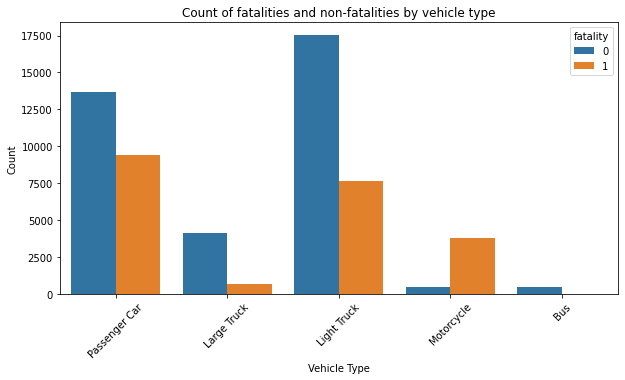

In [51]:
plt.figure(figsize=(10,5))
sns.countplot(x='vehicle_type', data=df, hue='fatality')
plt.xticks(rotation=45)
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.title('Count of fatalities and non-fatalities by vehicle type');
plt.savefig('Count_vehicle_type.png', bbox_inches='tight')

A fatality is coded as the positive label 1. We can see from the plot above that every vehicle has a higher proportion of non-fatal incidents than fatal ones, except for motorcycles, making this the most dangerous vehicle type to be driving (or being a passenger on) when in a fatal crash. The safest mode of transport appears to be riding on a bus, that looks to have a negligible number of deaths. 

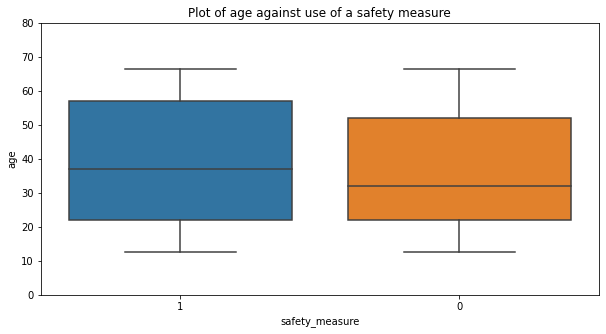

In [52]:
plt.figure(figsize=(10,5))
plt.ylim(0,80)
sns.boxplot(x='safety_measure', y='age',data=df)
plt.title('Plot of age against use of a safety measure');
plt.savefig('Boxplot_age_safety_measure.png', bbox_inches='tight')

The median age of those who use a safety feature is higher than those who do not, suggesting that younger people are more likely to engage in the risky behaviour of not wearing a seatbelt or using a helmet, although the spread across both classes is equal. Sadly we can see that there are very young people (around 12 to 13 years old) who are in crashes without being restrained. 

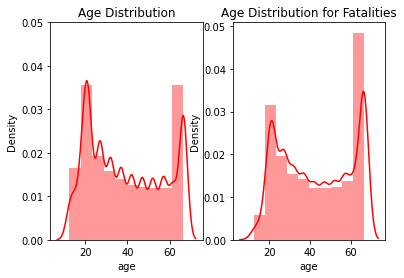

In [53]:
fig, ax =plt.subplots(1,2)

df1 = df[df['fatality'] == 1]

sns.distplot(df.age, color='red', bins=10, ax=ax[0])
ax[0].set_ylim(0,0.05)
ax[0].title.set_text('Age Distribution')


sns.distplot(df1.age, color='red', bins=10, ax=ax[1])
ax[1].title.set_text('Age Distribution for Fatalities')

plt.savefig('Age_distribution.png',bbox_inches='tight')

The overall age distribution for those involved in fatal crashes show a peak around 20 years and 65 years. When we look at this distribution for fatalities only we see that a lower proportion of young people die in these crashes and a larger proportion of older people die in these crashes. Both groups are equally involved in fatal crashes but older people are more likely to die. 

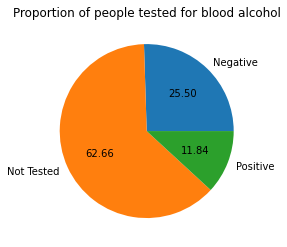

In [54]:
df.groupby('blood_alcohol').size().plot(kind='pie', autopct='%.2f')
plt.ylabel("")
plt.title('Proportion of people tested for blood alcohol');
plt.savefig('blood_alcohol_pie.png', bbox_inches='tight')

Two thirds of individuals in a crash do not have their blood tested for alcohol. Of the remaining third that are tested around 32% have a positive result, meaning 68% test negative. The question becomes, when do officers or other response teams decide to test for alcohol and when do they not? Perhaps these tests are only ordered when the person in question appears to be intoxicated, therefore even when they do not have alcohol present they may be under the influence of something else (like prescription drugs) which is impairing their ability to drive, but this information is not included in our dataset. 

### Looking for relevant features

Perform a chi-squared hypothesis test on each feature with the target to check for significant associations and remove those that show independence from the target. 

In [55]:
for i in df.columns:
    ct = pd.crosstab(df[i], df.fatality)
    p = stats.chi2_contingency(ct)[1]
    if p > 0.05:
        print('Fatality and {} are independent'.format(i))

Fatality and day_of_week are independent
Fatality and time_of_day are independent


The chi-squared tests show that at a 5% level of significance fatality and day of the week / time of the day are independent, meaning these features have no discernable relationship to the target variable (in terms of association).

As such they will be removed from the dataframe for the rest of the project. 

In [56]:
df = df.drop(columns=['day_of_week','time_of_day'])

In [57]:
df.columns

Index(['blood_alcohol', 'ejected', 'fatality', 'person_type', 'age',
       'safety_measure', 'vehicles_in_crash', 'manner_of_collision', 'state',
       'vehicle_type', 'impact_point', 'licence_status', 'speeding',
       'rollover'],
      dtype='object')

In [58]:
x = df[['blood_alcohol', 'ejected','person_type', 'age',
       'safety_measure', 'vehicles_in_crash', 'manner_of_collision', 'state',
       'vehicle_type', 'impact_point', 'licence_status', 'speeding',
       'rollover']]

y = df['fatality']

In [59]:
x_dum = pd.get_dummies(x)
x_dum.shape

(57882, 85)

In [60]:
x_train, x_test, y_train, y_test = train_test_split(
    x_dum, y, test_size=0.2, random_state=1, stratify=y)

In [61]:
# Fit the data with an ordinal encoder to perpare for a k-best algorithm

oe = OrdinalEncoder()
oe.fit(x_train)
x_train_enc = oe.transform(x_train)
x_test_enc = oe.transform(x_test)

In [62]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(x_train, y_train)
x_train_fs = fs.transform(x_train)
x_test_fs = fs.transform(x_test)

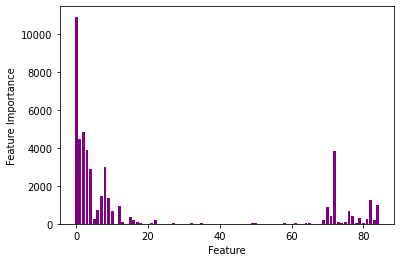

In [63]:
features = [i for i in x_dum.columns]
feature_importance = []

for i in range(len(fs.scores_)):
    feature_importance.append(fs.scores_[i])
    
plt.bar([i for i in range(len(fs.scores_))], fs.scores_, color='purple')
plt.xlabel('Feature')
plt.ylabel('Feature Importance');

plt.savefig('k_best_feature_importance.png',bbox_inches='tight')

In [64]:
# Make a dataframe of the most important features for association with the target

features_df = pd.DataFrame(
    {'Feature': features,
     'Feature_importance': feature_importance})

features_df_reduced = features_df[features_df.Feature_importance > 300]

reduced_features = features_df_reduced['Feature'].tolist()

features_df_reduced.sort_values(by='Feature_importance', ascending=False)


,Feature,Feature_importance
0,age,10911.990777
2,blood_alcohol_Not Tested,4845.382401
1,blood_alcohol_Negative,4454.760775
3,blood_alcohol_Positive,3912.578380
72,vehicle_type_Motorcycle,3826.662484
8,safety_measure_0,2980.676591
4,ejected_Ejected,2882.117833
7,person_type_Occupant,1461.455471
9,safety_measure_1,1334.208505
82,speeding_1.0,1266.519995


As we can see from the graph there are many of the dummified features which do not apparently predict well for the target as seen by thier low value of feature importance. I have made an arbitrary decision on where put a lower limit for a feature to be included at 300 to give the set of features above. This leaves us with 20 features from an original 85, which are shown in the table above. 

I would like to see if this set of reduced features works better in some of the later models than the full dummied dataset and so have saved them as a list of reduced features. 

## Initial Modelling

To begin I will perform some modelling with the full dataset with default parameters to get an inital accuracy score and to identify good models for further analysis and evaluation. Then I will perform the modelling with the subset of features identified by the K-best algoithm from the EDA section above to compare the accuracy scores. 

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, average_precision_score, plot_precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import naive_bayes
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler

In [66]:
y = df['fatality']

x_full = df[['blood_alcohol', 'ejected', 'person_type', 'age','safety_measure', 'vehicles_in_crash',
       'manner_of_collision', 'state', 'vehicle_type', 'impact_point','licence_status', 'speeding', 'rollover']]

In [67]:
# Calculating the baseline for each model (proportion of the majority class)

b = y.value_counts(normalize=True).max()

print('The baseline for the classification model is {}'.format(round(b,4)))

The baseline for the classification model is 0.6275


In [68]:
# Dummify the categorical variables

x_dum = pd.get_dummies(x_full)

In [69]:
# Split the training and test data, stratify by the target variable

x_train, x_test, y_train, y_test = train_test_split(
    x_dum, y, test_size=0.2, random_state=1, stratify=y)

In [70]:
# Rescale the data using the standard scalar

scaler = StandardScaler()

x_train_std = scaler.fit_transform(x_train)
x_test_std = scaler.transform(x_test)

x_train_std = pd.DataFrame(x_train, columns=x_dum.columns)
x_test_std = pd.DataFrame(x_test, columns=x_dum.columns)

In [71]:
# A range of classification models with default parameters

models = [LogisticRegression(max_iter=1000), DecisionTreeClassifier(), RandomForestClassifier(),
          ExtraTreesClassifier(), AdaBoostClassifier(), GradientBoostingClassifier(), KNeighborsClassifier()]

model_names = ['Logistic Regression','Decision Tree Classifier','Random Forest Classifier','Extra Trees Classifier',
              'Ada Boost Classifier', 'Gradient Boosting Classifier','K Nearest Neighbours', 'Multinomial Naive Bayes',
               'Categorical Naive Bayes']


In [72]:
# Basic model scoring function 

def model_accuracy(model, x_train, y_train, x_test, y_test, cv=5):
    
    # Fit the model 
    model.fit(x_train, y_train)
    
    # Find cross validated accuracy scores
    cv_scores = cross_val_score(model, x_train, y_train, cv=cv)
    cv_score = np.mean(cross_val_score(model, x_train, y_train, cv=cv))
    training_score = model.score(x_train, y_train)
    test_score = model.score(x_test, y_test)
    
    return cv_score, training_score, test_score

In [73]:
# Upload the scores from the various classification models with a full feature set to lists

mean_cv = []
training = []
test = []
for i in models:
    scores = model_accuracy(i, x_train_std, y_train, x_test_std, y_test, cv=5)
    mean_cv.append(scores[0])
    training.append(scores[1])
    test.append(scores[2])

In [74]:
# Since Naive Bayes models cannot be run on negative data it is necassary to use a different scaler for these models.
# Here I have used the min/max scaler that bounds the data between 0 and 1. 
# These models have then been run separately and the scores input to the DataFrame with the other models. 

scaler_2 = MinMaxScaler()

x_train_std_2 = scaler_2.fit_transform(x_train)
x_test_std_2 = scaler_2.transform(x_test)

x_train_std_2 = pd.DataFrame(x_train, columns=x_dum.columns)
x_test_std_2 = pd.DataFrame(x_test, columns=x_dum.columns)

In [75]:
# Instantiate Naive Bayes models

models_2 = [MultinomialNB(),CategoricalNB()]

In [76]:
# Add the scores from the Bayes models to the data frame

for i in models_2:
    scores = model_accuracy(i, x_train_std_2, y_train, x_test_std_2, y_test, cv=5)
    mean_cv.append(scores[0])
    training.append(scores[1])
    test.append(scores[2])

In [77]:
# Combine lists for the full feature set into a data frame

scores_df = pd.DataFrame({'Model' : model_names,
                          'Mean CV' : mean_cv,
                          'Training' : training,
                          'Test' : test})

scores_df['features'] = 'full'

scores_df

,Model,Mean CV,Training,Test,features
0,Logistic Regression,0.821402,0.822114,0.820506,full
1,Decision Tree Classifier,0.803045,0.967563,0.798393,full
2,Random Forest Classifier,0.832761,0.967541,0.830440,full
3,Extra Trees Classifier,0.825030,0.967563,0.823616,full
4,Ada Boost Classifier,0.821639,0.822697,0.823011,full
5,Gradient Boosting Classifier,0.841637,0.843537,0.839596,full
6,K Nearest Neighbours,0.809653,0.864291,0.809795,full
7,Multinomial Naive Bayes,0.799050,0.799482,0.797098,full
8,Categorical Naive Bayes,0.788964,0.789375,0.785091,full


### Analysis

The logistic regression model appears to be a suitable candidate, with very similar CV / training / test scores suggesting a consistent model that trains well on unseen data. The three tree classifiers show a massive overfit as evidenced by the inflated training scores, these trees likely require pruning, or to be given a smaller subset of features to grow with, although it is interesting to note the Random Forest Classifier has one of the largest mean CV scores, despite this overfit. The gradient booster models have also performed well, with the strongest being the 'gradient boosting classifier', another consistent model. 

The Naive Bayes models will be left out of futher analysis, as well as being the most poorly performing models they tend to be more useful for higher dimensional data, whereas we will be decreasing the dimensions in the next section. 

In [78]:
# Construct a new features set using the reduced features identified by the Kbest chi-squared algorithm

x_dum_red = x_dum[reduced_features]
x_dum_red.shape

(57882, 20)

In [79]:
# New train test split for reduced features

x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(
    x_dum_red, y, test_size=0.2, random_state=1, stratify=y)

In [80]:
# New scaled reduced features 

scaler = StandardScaler()

x_train_std_r = scaler.fit_transform(x_train_r)
x_test_std_r = scaler.transform(x_test_r)

x_train_std_r = pd.DataFrame(x_train, columns=x_dum_red.columns)
x_test_std_r = pd.DataFrame(x_test, columns=x_dum_red.columns)

In [81]:
# Add the scores from the reduced feature set models to lists 

mean_cv = []
training = []
test = []

for i in models:
    scores = model_accuracy(i, x_train_std_r, y_train_r, x_test_std_r, y_test_r, cv=5)
    mean_cv.append(scores[0])
    training.append(scores[1])
    test.append(scores[2])

In [82]:
# Model names for reduced features set 

model_names = ['Logistic Regression','Decision Tree Classifier','Random Forest Classifier','Extra Trees Classifier',
              'Ada Boost Classifier', 'Gradient Boosting Classifier','K Nearest Neighbours']

In [83]:
# Create a data frame showing the scores from the reduced features set models

scores_df_2 = pd.DataFrame({'Model' : model_names,
                            'Mean CV' : mean_cv,
                            'Training' : training,
                            'Test' : test})

scores_df_2['features'] = 'reduced'

scores_df_2

,Model,Mean CV,Training,Test,features
0,Logistic Regression,0.814599,0.815268,0.812214,reduced
1,Decision Tree Classifier,0.813497,0.866969,0.816274,reduced
2,Random Forest Classifier,0.821445,0.866969,0.821802,reduced
3,Extra Trees Classifier,0.816953,0.866969,0.820852,reduced
4,Ada Boost Classifier,0.816758,0.815981,0.811609,reduced
5,Gradient Boosting Classifier,0.833668,0.835461,0.830267,reduced
6,K Nearest Neighbours,0.810128,0.832826,0.803058,reduced


In [84]:
# Concat the two scoring data frames and sort by highest Mean CV score

scores = pd.concat([scores_df, scores_df_2], ignore_index=True)
scores.sort_values(by=['Mean CV','Training','Test'], ascending=False)

,Model,Mean CV,Training,Test,features
5,Gradient Boosting Classifier,0.841637,0.843537,0.839596,full
14,Gradient Boosting Classifier,0.833668,0.835461,0.830267,reduced
2,Random Forest Classifier,0.832761,0.967541,0.830440,full
3,Extra Trees Classifier,0.825030,0.967563,0.823616,full
4,Ada Boost Classifier,0.821639,0.822697,0.823011,full
11,Random Forest Classifier,0.821445,0.866969,0.821802,reduced
0,Logistic Regression,0.821402,0.822114,0.820506,full
12,Extra Trees Classifier,0.816953,0.866969,0.820852,reduced
13,Ada Boost Classifier,0.816758,0.815981,0.811609,reduced
9,Logistic Regression,0.814599,0.815268,0.812214,reduced


In [85]:
scores_CI = scores.reset_index()

In [86]:
scores_CI['Lower'] = scores_CI['Mean CV']
scores_CI['Upper'] = scores_CI['Mean CV']

for i in range(len(scores_CI)):
    scores_CI.Model[i] = scores_CI.Model[i] + ' - ' + scores_CI.features[i]

<ipython-input-86-d393360921a9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_CI.Model[i] = scores_CI.Model[i] + ' - ' + scores_CI.features[i]


In [87]:
scores_CI = scores_CI.drop(columns =['index','Training','Test','features'])

In [88]:
def CI_lower(x):
    y = x + 1.96 *((x * (1 - x)) / 57882)**0.5
    return y 

def CI_upper(x):
    y = x - 1.96 * ((x * (1 - x)) / 57882)**0.5
    return y 

In [89]:
scores_CI.Lower = scores_CI.Lower.map(CI_lower)
scores_CI.Upper = scores_CI.Upper.map(CI_upper)

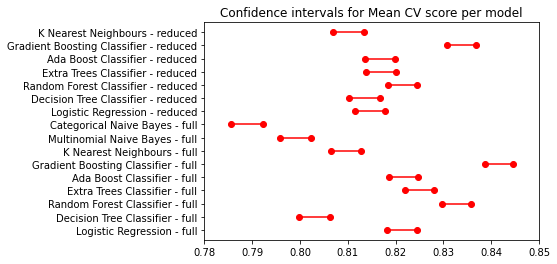

In [90]:
for lower,upper,y in zip(scores_CI['Lower'],scores_CI['Upper'],range(len(scores_CI))):
    plt.plot((lower,upper),(y,y),'ro-')
    plt.xlim(0.78,0.85)
plt.title('Confidence intervals for Mean CV score per model')
plt.yticks(range(len(scores_CI)),list(scores_CI['Model']));

plt.savefig('CI_inital_models.png', bbox_inches='tight')

### Analysis

The most promising model is the Gradient Boosting Classifier, which performed well with both sets of features, but better with the full set. The reduced set of features helped both the Extra Trees classifier and the Random Forest Classifier's overfitting problem, but at the expense of decreasing scores across the model as a whole. these models may still be possible candidates, but the remaining overfit on the training set means the features could use further pruning. The next appropriate model is the Logistic Regression because although this model had a slightly lower Mean CV score than some of the others, it has very close scores across all measures, suggesting a stable model. In order to pursue both a black box and white box model (for interpretability) I will further investigate the Gradient Boosting Classifier and the Logistic Regression Model, both with the full set of features, as identified by the table above. 

## Model Tuning

The most promising models from the previous section are the Gradient Boosting Classifer with the full features set and the Logistic Regression model, also on the full features set. I will now attempt to increase the accuracy, or other scoring metrics, of these models by tuning the hyperparameters with a GridSearch and by using Bagging models. The optimised models will then be evaluated for quality / usefullness.  

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, average_precision_score, plot_roc_curve, plot_precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm
from yellowbrick.classifier import DiscriminationThreshold
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

In [92]:
# A function to interpret a classification model, giving various accuracy scores, the log loss,
# the confusion matrix, the classification report and the ROC and precision recall curves. 

def classification_model_interpreter(model, x_train, y_train, x_test, y_test, cv=5):
    
    # Fit the model
    model.fit(x_train, y_train)
    
    # Cross validated accuracy scores 
    cv_scores = cross_val_score(model, x_train, y_train, cv=cv)
    print('CV Scores: ', cv_scores)
    
    cv_score = np.mean(cross_val_score(model, x_train, y_train, cv=cv))
    training_score = model.score(x_train, y_train)
    test_score = model.score(x_test, y_test)
    print('Mean CV Score: {}'.format(cv_score))
    print('Training Score: {}'.format(training_score))
    print('Test Score: {}'.format(test_score))
    
    # Log loss scores
    log_loss_train = log_loss(y_train, model.predict_proba(x_train))
    log_loss_test = log_loss(y_test, model.predict_proba(x_test))
    print('Log loss for training set: {}'.format(log_loss_train))
    print('Log loss for test set: {}'.format(log_loss_test))
    
    # Confusion Matrix
    print('Training Confusion Matrix')
    plot_confusion_matrix(model, x_train, y_train, cmap='Blues', values_format='.5f', normalize='true', labels=[1,0])
    plt.show()
    
    # Classification report 
    predictions = model.predict(x_train)
    print(classification_report(y_train, predictions, digits=4))
    
    # ROC Curve
    fig, ax = plt.subplots(figsize=(6, 6))
    plot_roc_curve(model, x_train, y_train, ax=ax)
    ax.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.show()

    roc_auc_score(y_train, model.predict_proba(x_train)[:, 1])

    # Precision recall curve
    fig, ax = plt.subplots(figsize=(6, 6))
    plot_precision_recall_curve(model, x_train, y_train, ax=ax)
    plt.show()

    average_precision_score(y_train, model.predict_proba(x_train)[:, 1])

### Model Tuning the Gradient Boosting Classifier

In [56]:
# Gradient Boosting Model without hyperparameter tuning (manually selected parameters)

gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                max_depth=1, random_state=0)

model_accuracy(gb_model, x_train_std, y_train, x_test_std, y_test, cv=5)

(0.8231724435806068, 0.8243602202785876, 0.8250842187095102)

In [57]:
# Grid search for Gradient Boosting model 

gb_params = {'learning_rate':[0.3,0.4,0.5],
            'n_estimators':[40,50,60],
            'subsample':[0.5,0.6],
            'min_samples_leaf':[2,3,4],
            'max_features':[10,11,12]}

gb_gs = GridSearchCV(GradientBoostingClassifier(), gb_params,verbose=1, cv=5, n_jobs=-1)

gb_gs.fit(x_train_std, y_train)
gb_gs.score(x_train_std,y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


0.845761796782205

In [58]:
gb_gs.best_params_

{'learning_rate': 0.5,
 'max_features': 10,
 'min_samples_leaf': 3,
 'n_estimators': 60,
 'subsample': 0.6}

In [93]:
# Best parameters for Gradient Boosting Model as identified by the gridsearch

best_gb_gs = GradientBoostingClassifier(learning_rate=0.5,
min_samples_leaf=3, n_estimators=60, subsample=0.6, max_features=10)

CV Scores:  [0.8478566  0.84224166 0.83414318 0.84440125 0.83079581]
Mean CV Score: 0.842457617967822
Training Score: 0.8461289277615808
Test Score: 0.8427053640839596
Log loss for training set: 0.35172483933649507
Log loss for test set: 0.3605410144543856
Training Confusion Matrix


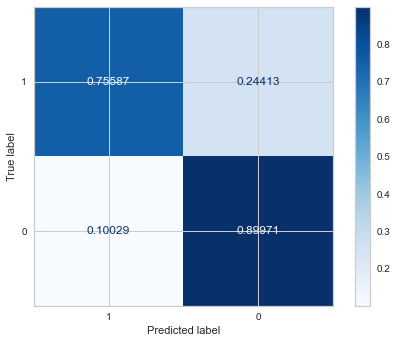

              precision    recall  f1-score   support

           0     0.8613    0.8997    0.8801     29056
           1     0.8173    0.7559    0.7854     17249

    accuracy                         0.8461     46305
   macro avg     0.8393    0.8278    0.8327     46305
weighted avg     0.8449    0.8461    0.8448     46305



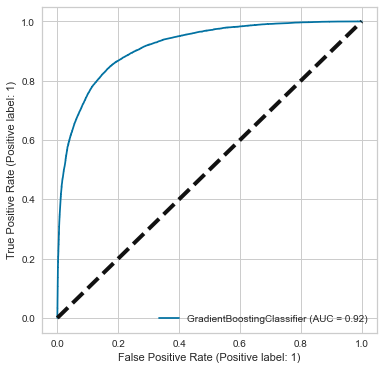

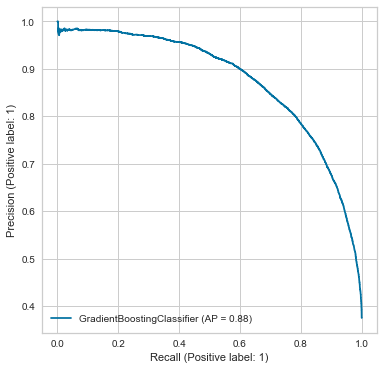

In [60]:
# Classification model interpreter for Gradient Boosting Model 

classification_model_interpreter(best_gb_gs, x_train_std, y_train, x_test_std, y_test, cv=5)

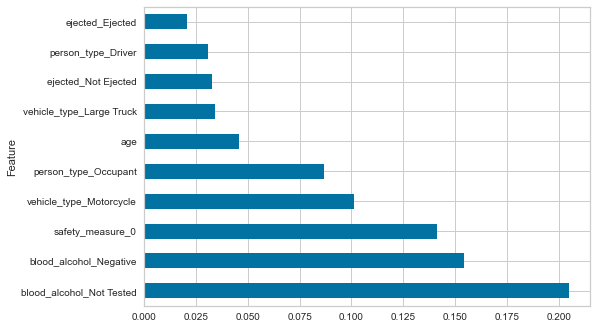

In [61]:
best_gb_gs_coef = pd.DataFrame(list(zip(x_train.columns, best_gb_gs.feature_importances_)))
best_gb_gs_coef.columns = ['Feature', 'Coef']
sorted_coef = best_gb_gs_coef.sort_values(by='Coef', ascending = False)
sorted_coef
non_zero_coef = sorted_coef[sorted_coef.Coef != 0]
non_zero_coef.set_index('Feature', inplace=True)
non_zero_coef.head(15)


# Plot of coefficients
non_zero_coef.Coef.head(10).plot(kind='barh');

### Gradient Boosting Classifier Interpretation and Evaluation

The Gradient Boosting Classifier has performed very well with an overall accuracy rate of around 86% on the training data (slightly higher than the mean CV score, but not to a level of concern). The log loss for both the test and training set is low at around 33% and 35%, respectively. The class 0 label (that is, those to live) is very well predicted, with only 9% being misclassified as deceased incorrectly, which fits with this being the majority class. 

The results for the minority positive class of 1 are less favourable, which is not unexpected, with 23% of those individuals who died being classed as living. This is a major problem in a practical sense for our model, as we are interested in decreasing the number of people who die in these accidents. This imbalance is discussed and accounted for later in the project. 

The AUC for the ROC curve, which tells us how well the model is capable of distinguishing between classes, is very favourable at 93% and the AP (Average Precision) is also high at 90%. 

Overall this is an excellent model with some impressive scores. The baseline accuracy for the model was around 62% so we have exceeded this by 24%. The current issue with this model is the large rate of false negatives, this needs to be addressed in order to answer the initial question of the project and will require us to increase the recall score (simultaneously decreasing the precision score). 


### Wrap the Gradient Boosting Classifier with a Bagging Classifier to attempt to increase accuracy 

In [62]:
bc_gb = BaggingClassifier(GradientBoostingClassifier(learning_rate=0.1,
min_samples_leaf=1, n_estimators=100, subsample=1.0, max_depth=5, loss='deviance', min_samples_split=5))

In [63]:
model_accuracy(bc_gb, x_train_std, y_train, x_test_std, y_test, cv=5)

(0.8498866213151928, 0.8578339272216823, 0.849615617171979)

In [64]:
# Grid search for Bagging Classifier with a gradient boosting classifier base estimator 

bc_params = {'n_estimators':[30,40,50],
            'max_samples':[0.9,1.0],
            'max_features':[0.9,1.0]}

bc_gb_gs = GridSearchCV(BaggingClassifier(GradientBoostingClassifier(learning_rate=0.1,
                    min_samples_leaf=1, n_estimators=100, subsample=1.0, max_depth=5, loss='deviance', 
                    min_samples_split=5)),bc_params,verbose=1, n_jobs=-1, cv=5)

bc_gb_gs.fit(x_train_std, y_train)
bc_gb_gs.score(x_train_std,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


0.8575747759421228

In [65]:
bc_gb_gs.best_params_

{'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 30}

In [66]:
best_bc_gb = BaggingClassifier(GradientBoostingClassifier(learning_rate=0.1,
min_samples_leaf=1, n_estimators=100, subsample=1.0, max_depth=5, loss='deviance', min_samples_split=5),
                              n_estimators=30 ,max_samples=1.0 ,max_features=1.0 )

In [67]:
model_accuracy(best_bc_gb, x_train_std, y_train, x_test_std, y_test, cv=5)

(0.8499298131951193, 0.8578123312817191, 0.8494428608447785)

The Bagging Classifier with the Gradient Boosting Classifier has not improved the accuracy score of the model further, hence this model will not be investigated further.  

### Model Tuning the Linear Regression Model 

Although the accurach scores of the Linear Regression Model are lower than a number of the other models, it has the advantage of being white box and therefore more interpretable in terms of understanding how each coefficient relates to the classes in the fatality target. 

In [68]:
# Start of Logistic Regression model, tune hyperparameters with gridsearch

LR_model = LogisticRegression(max_iter=1000)

gs_params = { 'penalty' : ['l2'],
              'solver': ['newton-cg','sag','lbfgs'],
              'C': np.logspace(-3, 0, 50)}

lr_gridsearch = GridSearchCV(LR_model,
                             gs_params,
                             n_jobs=-1, 
                             cv=5, 
                             verbose=1)

lr_gridsearch.fit(x_train, y_train)

lr_gridsearch.best_params_

Fitting 5 folds for each of 150 candidates, totalling 750 fits


/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'C': 0.06866488450043001, 'penalty': 'l2', 'solver': 'newton-cg'}

In [69]:
best_lr = LogisticRegression(C = 0.025595479226995357, penalty= 'l2', solver= 'newton-cg')

CV Scores:  [0.82971601 0.82226541 0.81503077 0.82150956 0.81265522]
Mean CV Score: 0.8202353957455999
Training Score: 0.8210776374041681
Test Score: 0.8207653105294982
Log loss for training set: 0.39296689650382804
Log loss for test set: 0.397200130076861
Training Confusion Matrix


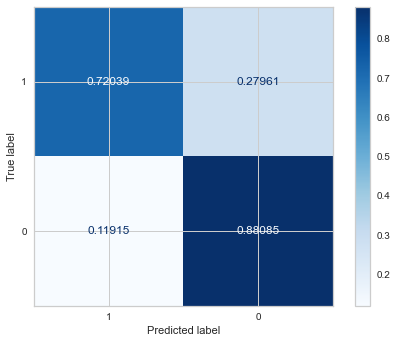

              precision    recall  f1-score   support

           0     0.8414    0.8809    0.8607     29056
           1     0.7821    0.7204    0.7500     17249

    accuracy                         0.8211     46305
   macro avg     0.8118    0.8006    0.8053     46305
weighted avg     0.8193    0.8211    0.8195     46305



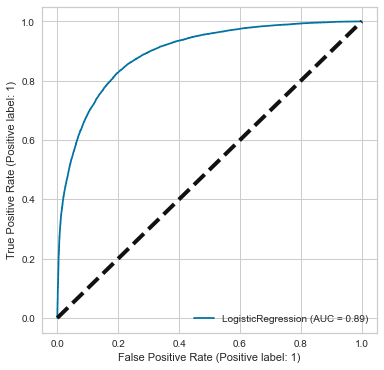

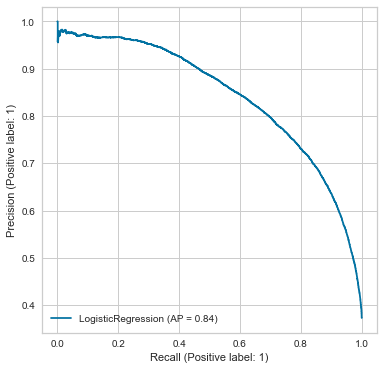

In [70]:
classification_model_interpreter(best_lr, x_train, y_train, x_test, y_test, cv=5)

### Logistic Regression Model Analysis and Evaluation 

We can see from the Logistic Regression model report that overall the model performed less favourably than the gradient boosting classifier in terms of accuracy and log loss for both the training and test sets. The AUC and AP numbers are also lower with 89% and 84% respectively (down from 93% and 90%).

Again we see a fairly large proportion of false negatives at 28% of the total number of deaths, larger even than the gradient boosting classifier. Again this is a problem for the practical application of the model. The advantage of the logistic regression model however is that we can interpret the coefficients of the model as counting for the positive or negative class. This is addressed below. 

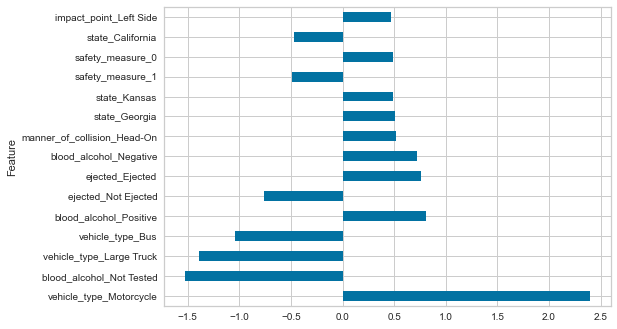

In [71]:
best_lr_coef = pd.DataFrame(list(zip(x_train.columns, best_lr.coef_[0])))
best_lr_coef.columns = ['Feature', 'Coef']
best_lr_coef['Absolute Coef'] = best_lr_coef.Coef.abs()
sorted_coef = best_lr_coef.sort_values(by='Absolute Coef', ascending = False)
sorted_coef
non_zero_coef = sorted_coef[sorted_coef.Coef != 0]
non_zero_coef.set_index('Feature', inplace=True)
non_zero_coef.head(15)


# Plot of coefficients
non_zero_coef.Coef.head(15).plot(kind='barh');

The coefficients above who those contributing to death on the positive x-axis and those contributing to life on the negative x-axis. Not suprisingly being on a motorcycle is the largest predictor for death, this was suggested by the graph in the EDA section of the project. Being ejected / having a head on collision (and therefore the largest relative speed with the other vehicle) and not using safety measure are also predictors of death, all intuitive outcomes. 

The largest predictors for the other class of life are being in a large vehicle (a bus or a truck), not being ejected, and using a safety measure, again all intutive outcomes. 

The strangest outcome again is the idea that having either a negative or a positive blood alcohol test predicts for death, whereas not having a test predicts for life. This oddity is a recurring theme in this project and is addressed in the further investigations section below. 

In [72]:
# Wrap a bagging model around the logistic regression and score again

lr_bc_params = {
          'max_features': [x/10 for x in range(2,11,2)],
          'max_samples': [x/10 for x in range(2,11,2)],
          'n_estimators': [10*x for x in range(2,11,2)]}

lr_bc_gs = GridSearchCV(BaggingClassifier(LogisticRegression(C = 0.025595479226995357, penalty= 'l2', 
                                        solver= 'newton-cg')), lr_bc_params,verbose=1, cv=5, n_jobs=-1)

lr_bc_gs.fit(x_train_std, y_train)
lr_bc_gs.score(x_train_std,y_train)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0.8214663643235072

In [76]:
lr_bc_gs.best_params_

{'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 20}

In [77]:
best_lr_bc = BaggingClassifier(LogisticRegression(C = 0.025595479226995357, penalty= 'l2', solver= 'newton-cg'),
                             max_samples=1.0, max_features=1.0 , n_estimators=20)

In [78]:
model_accuracy(best_lr_bc, x_train, y_train, x_test, y_test, cv=5)

(0.8205161429651225, 0.8215095562034338, 0.820333419711497)

The GridSearch Bagging Classifier for Logistic Regression did not yeild better accuracy scores than the optimized Logistic Regression model, hence there is no need to look further into these results.

### Fitting a feed forward multi-layer perceptron  (Neural Net) 

In [81]:
clf_full = MLPClassifier(solver='lbfgs',
                    alpha=10**(-10),
                    hidden_layer_sizes=1,
                    activation='identity',
                    random_state=1,
                    batch_size='auto',
                    max_iter=1000
                   )
clf_full.fit(x_train_std, y_train)
print(metrics.accuracy_score(y_train, clf_full.predict(x_train_std)))

0.6386567325342836


In [83]:
clf_reduced = MLPClassifier(solver='lbfgs',
                    alpha=10**(-10),
                    hidden_layer_sizes=1,
                    activation='identity',
                    random_state=1,
                    batch_size='auto',
                    max_iter=1000
                   )
clf_reduced.fit(x_train_std_r, y_train)
print(metrics.accuracy_score(y_train, clf_reduced.predict(x_train_std_r)))

0.8152899254940071


As we can see the full set of features gives a training scores that is barely above the baseline. The scores are better for the reduced set of features, which gives an accuracy training score of 0.815. I will now attempt cross-validation and further tuning in order to improve and evaluate this score. For this model I will use a Random Search rather than a Grid Search in order to decrease the computational cost of the model.

In [84]:
model_accuracy(clf_reduced, x_train_std_r, y_train_r, x_test_std_r, y_test_r)

(0.8145340675952919, 0.8152899254940071, 0.8122138723330742)

The neural net gives a stable model, as shown by the close scores in for the Mean CV,  training set and test set. 

In [85]:
random_grid = {'solver':['lbfgs','sgd','adam'],
               'alpha': [0.00001,0.0001,0.001,0.01],
               'activation': ['identity','logistic','tanh','relu'],
               'batch_size' : ['auto',20,40,60,100]}
               

model = MLPClassifier(hidden_layer_sizes=(4,4,4,4), max_iter=1000)

rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 50, cv = 5, 
                               verbose=2, random_state=35, n_jobs = -1)

rf_random.fit(x_train_std_r,y_train_r)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=MLPClassifier(hidden_layer_sizes=(4, 4, 4, 4),
                                           max_iter=1000),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'alpha': [1e-05, 0.0001, 0.001, 0.01],
                                        'batch_size': ['auto', 20, 40, 60, 100],
                                        'solver': ['lbfgs', 'sgd', 'adam']},
                   random_state=35, verbose=2)

In [86]:
rf_random.best_score_

0.8333009394233883

In [87]:
rf_random.best_params_

{'solver': 'adam', 'batch_size': 100, 'alpha': 1e-05, 'activation': 'logistic'}

In [88]:
nn_model = MLPClassifier(hidden_layer_sizes=(4,4,4,4), max_iter=1000, solver='adam',batch_size=40,
                     alpha=0.001, activation='logistic')

In [89]:
model_accuracy(nn_model, x_train_std_r, y_train_r, x_test_std_r, y_test_r)

(0.8314436885865458, 0.8328258287441961, 0.8339811695603352)

We can see that the accuracy of the Neural Network model trained on the best parameters from the RandomCV search has high accuracy and good consistency, in fact the accuracy scores for this model are better than the optimised Logistic Regression model detailed above. However, the other black box model we have used (i.e the Gradient Boosting Classifier) still has the largest accuracy scores and still serves as the most appropriate model. 

### Changing the threshold of the model to improve scores relevant to fatalities (false negatives) 

We would like to decrease the rate of false negatives, these values represent situations where we have predicted the person will live when actually they will die. Not sending emergency services in a serious situation could be fatal, whereas sending emergency services or using other resources when someone lives has a lower cost to life. As such, we can tailor the probability threshold of the predictions to favour a decrease in the rate of false negatives. We will do this procedure on the best scoring model, which is the gradient boosting classifier. 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


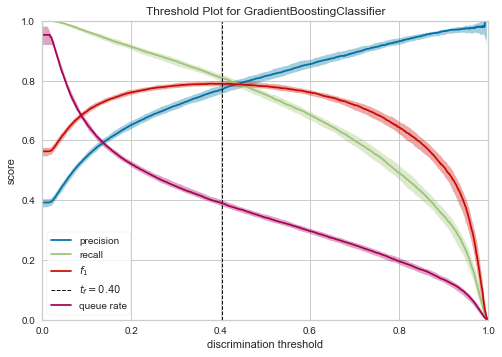

In [90]:
visualizer = DiscriminationThreshold(best_gb_gs)

visualizer.fit(x_train_std, y_train)  

visualizer.finalize()

The discrimination threshold plot shows the varying scores for the classification model across different probability thresholds. The vertical dashed-line shows the optimised F1 score, that is the maximum harmonic mean between precision and recall. This will serve as the new threshold for the model in order to strike the correct balance between between a decrease in false negative and an increase in false positives, representing a balance between the loss of human life and the cost of resources. 

In [91]:
y_train_pp = pd.DataFrame(best_gb_gs.predict_proba(x_train), 
             columns=['Live', 'Die'])
y_train_pp.head()

,Live,Die
0,0.874734,0.125266
1,0.964649,0.035351
2,0.827756,0.172244
3,0.621818,0.378182
4,0.975321,0.024679


In [95]:
# A function to return the predictions based on an amended probability threshold

def predict_at_threshold(x, threshold=0.4):
    if x >= threshold:
        return 1
    else:
        return 0

In [96]:
y_train_pp['Predicted labels'] = y_train_pp.Die.map(predict_at_threshold)
predictions = y_train_pp['Predicted labels']

In [97]:
# Compute the confusion matrix for the amended probability threshold

confusion_matrix(y_train, predictions, normalize='true')

array([[0.86037307, 0.13962693],
       [0.18940228, 0.81059772]])

The decreased threshold has decreased the proportion of false negatives from 23%, however this suggests that of those who die we are still mis-classifying around 16% as those who will live, which a large moral implication for the preservation of life (in terms of real numbers this would be around 3500 people). 

We could continue to decrease the probability threshold and continue to decrease the number of false negatives. However there is a trade off, when we do this the proportion of false positives also increase, that is our predictions say the person will die when actually they will live and this may also have an impact on the preservation of life. Given the scarce resources in the police and medical fields we may end up sending resources to crash sites that are not needed, decreasing the resources available for other emergencies.

The optimised F1 score given by the 'Yellow Brick' discrimination threshold plot, which occurs at 39%, gives us the optimum value for finding a middle ground between these concerns. 

## Further investigation

1. Blood alcohol being tested and coming out positive or negative comes up consistently as an indicator for death. Blood alcohol not being tested consistently comes up as an indicator for life. Why might this be? The answer may lie in when officers (or other professionals) decide to do a blood test on those involved in crashes. One might assume that this happens only when the person appears intoxicated or the officer has reason to believe the person may be intoxicated, hence when they get a negative blood alcohol test there is a change they may be impaired in some other way. When I looked at some of these negative tests within other data provided by the FARS database this did seem to be the case (For example one individual who had a negative blood alcohol test did test positive for both amphetamines and methamphetamines, whereas another instance I investigated did not uncover any substances). With more time I would like to remove the blood alcohol test as a predictor and replace it with an intoxication predictor which tells whether the person had any substances in their bloodstream which would impair driving, whether these are illegal or legal. 


2. When we ran the chi-squared tests for predictor strengths the age variable came 2-3 times larger than any other predictor, suggesting this would be a good indicator for the target. However, when we looked at the top 15 coefficients for the Logistic Regression Model ‘age’ did not appear at all. It is possible that the signal for age is being coded within other predictors (for example riding a motorcycle, which may be more associated with young people), but further investigation is required to discern whether this is the case and why there is a discrepancy between the predictors identities by the chi-squared test and those identified by the Logistic Regression Model. 